[View in Colaboratory](https://colab.research.google.com/github/andreinechaev/Dermotology_CNN/blob/master/SkinScanner.ipynb)

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import csv
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img

%matplotlib inline

Using TensorFlow backend.


In [0]:
### Helper functions

def normalize(img, beta=255):
  cv2.normalize(img, img, alpha=0, beta=beta, norm_type=cv2.NORM_MINMAX)

def to_grayscale(img):
  return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def resize(img, size=(224, 224)):
  height, width = img.shape[:2]

  if height > width:
      diff = height - width
      pad = int(diff / 2)
      res = img[pad:height - pad, :]
  elif width > height:
      diff = width - height
      pad = int(diff / 2)
      res = img[:, pad:width - pad]
  else:
      res = img

  return cv2.resize(res, size)
  
def reshape(img):
  height, width = img.shape[:2]
  tmp = img_to_array(img)  # this is a Numpy array with shape (224, 224, 3)
  return tmp# tmp.reshape((3, height, width))

In [14]:
!pip install lxml

In [0]:
!mkdir data

In [17]:
import requests
from lxml import html
import os
import cv2
import numpy as np
import csv


if __name__ == '__main__':
    resp = requests.get('https://medicine.uiowa.edu/dermatology/education/clinical-skin-disease-images')

    if resp.status_code != 200:
        exit(1)

    tree = html.fromstring(resp.content)
    elements = tree.xpath('//*[@id="content"]/div/div[1]/div/article/div/div/div/div/ul')

    disease_map = {}

    for elem in elements:
        link_elements = elem.xpath('li/a')
        for le in link_elements:
            link = le.attrib['href']
            index = link.rindex('/')
            name = link[index + 1:]
            disease_map[name] = link

    dis_images = []
    for k, v in disease_map.items():
        r = requests.get('https:' + v)
        t = html.fromstring(r.content)
        p_elems = t.xpath('//*[@id="content"]/div/div[1]/div/article/div/div/div/div/p')

        images = []
        for e in p_elems:
            img = e.xpath('img')
            for i in e:
                link = i.attrib['src']
                images.append('https:' + link)

        dis_images.append((k, images))

    length = 0
    for dis in dis_images:
        length += len(dis[1])

    print(f"Got {length} links")

    with open('data/meta.csv', 'w+') as csv_file:
        writer = csv.writer(csv_file, quoting=csv.QUOTE_ALL, escapechar='\\', quotechar='"')
        t = 0
        for dis in dis_images:
            path = 'data/' + dis[0]
            os.mkdir('data/' + dis[0])
            for l in dis[1]:
                index = l.rindex('/')
                file = path + '/' + l[index + 1:]
                resp = requests.get(l)
                arr = np.asarray(bytearray(resp.content), dtype=np.uint8)
                img = cv2.imdecode(arr, -1)
                img = resize(img)
                cv2.imwrite(file, img)
                fields = [t, dis[0], file]
                writer.writerow(fields)
            t += 1

    print('Done')

Got 374 links
Done


In [0]:
names = []
labels = []
images = []
with open('data/meta.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        labels.append(row[0])
        names.append(row[1])
        img = cv2.imread(row[2])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        normalize(img)
        images.append(img)

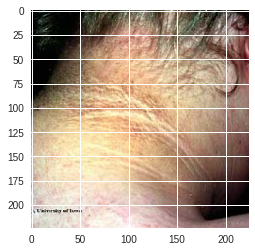

In [26]:
plt.imshow(images[0])

In [27]:
from sklearn.model_selection import train_test_split

sorted_classes, class_indices, class_counts = np.unique(labels, return_index=True, return_counts=True)
n_classes = len(sorted_classes)

# images = [np.reshape(i, (3, 224, 224)) for i in images]
images, test_images, labels, test_labels = train_test_split(images, labels, test_size=0.12, random_state=0)

n_train = len(images)

n_test = len(test_images)

image_shape = images[0].shape

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 329
Number of testing examples = 45
Image data shape = (224, 224, 3)
Number of classes = 167


In [28]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD

model = Sequential()
# model.add(Conv2D(32, (3, 3), input_shape=(3, 224, 224)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

# model.add(Conv2D(32, (3, 3), data_format="channels_first"))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(167, activation='softmax'))

# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy',
#               optimizer=sgd,
#               metrics=['accuracy'])

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(167, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

images = [reshape(i) for i in images]
test_images = [reshape(i) for i in test_images]

print(f"Reshaped image: {images[0].shape}")

Reshaped image: (224, 224, 3)


In [29]:
from keras.utils import np_utils
from keras.callbacks import TensorBoard
from time import time

batch_size = 64
epochs = 50



# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

x_train = np.array(images)
y_train = np_utils.to_categorical(labels, n_classes)

print(f"x_train shape: {x_train.shape}")

x_test = np.array(test_images)
y_test = np_utils.to_categorical(test_labels, n_classes)

train_datagen.fit(images)

history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(images)/batch_size, epochs=epochs,
                    validation_data=test_datagen.flow(x_test, y_test, batch_size=batch_size),
                    validation_steps=len(images)/2/batch_size, verbose=0)

model.save_weights('first_try.h5')

x_train shape: (329, 224, 224, 3)


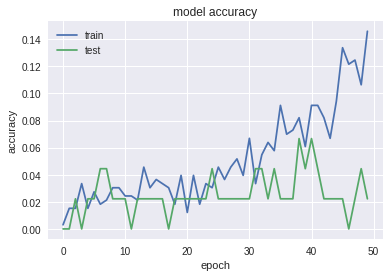

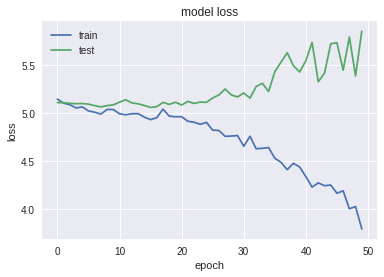

In [30]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
model.evaluate(x_test, y_test)

45/45 [==============================] - 0s 3ms/step


[16.11809539794922, 0.0]

image shape (224, 224, 3)


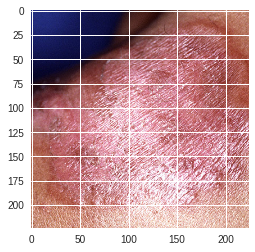

In [22]:
import requests
link = 'https://clf1.medpagetoday.com/assets/images/resource-center/cs-neutrophilic-dermatosi-RM-600x400.jpg'

def download(url):
  resp = requests.get(link)
  arr = np.asarray(bytearray(resp.content), dtype=np.uint8)
  img = cv2.imdecode(arr, -1)
  return resize(img)

img = download(link)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

img = reshape(img) / 255.
print(f"image shape {img.shape}")

In [23]:
req = np.array(img[np.newaxis, ...])
vals = model.predict_classes(req, verbose=1)

for num in vals:
  print(f"It might be {names[num]}")

1/1 [==============================] - 0s 195ms/step
It might be cellulitis


In [159]:
vals = model.predict_classes(req, verbose=1)

for num in vals:
  print(f"It might be {names[num]}")

1/1 [==============================] - 0s 5ms/step
It might be erythema-multiforme
